In [80]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

%matplotlib inline

In [81]:
# Import Model building package
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
# Supervised
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.ensemble import RandomForestClassifier 
# Unsupervised
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
# Evaluate model performace
from sklearn import metrics #for checking the model accuracy


## Load data 

In [2]:
data = pd.read_csv("../data/Identifying Fraudulent Activities/Fraud/Fraud_Data.csv")
ip2country = pd.read_csv("../data/Identifying Fraudulent Activities/Fraud/IpAddress_to_Country.csv")

In [3]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
ip2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [5]:
map_country = ip2country.loc[1,:]

## Explotary data analysis

- Source Direct has lowest volume but highest fraud rate

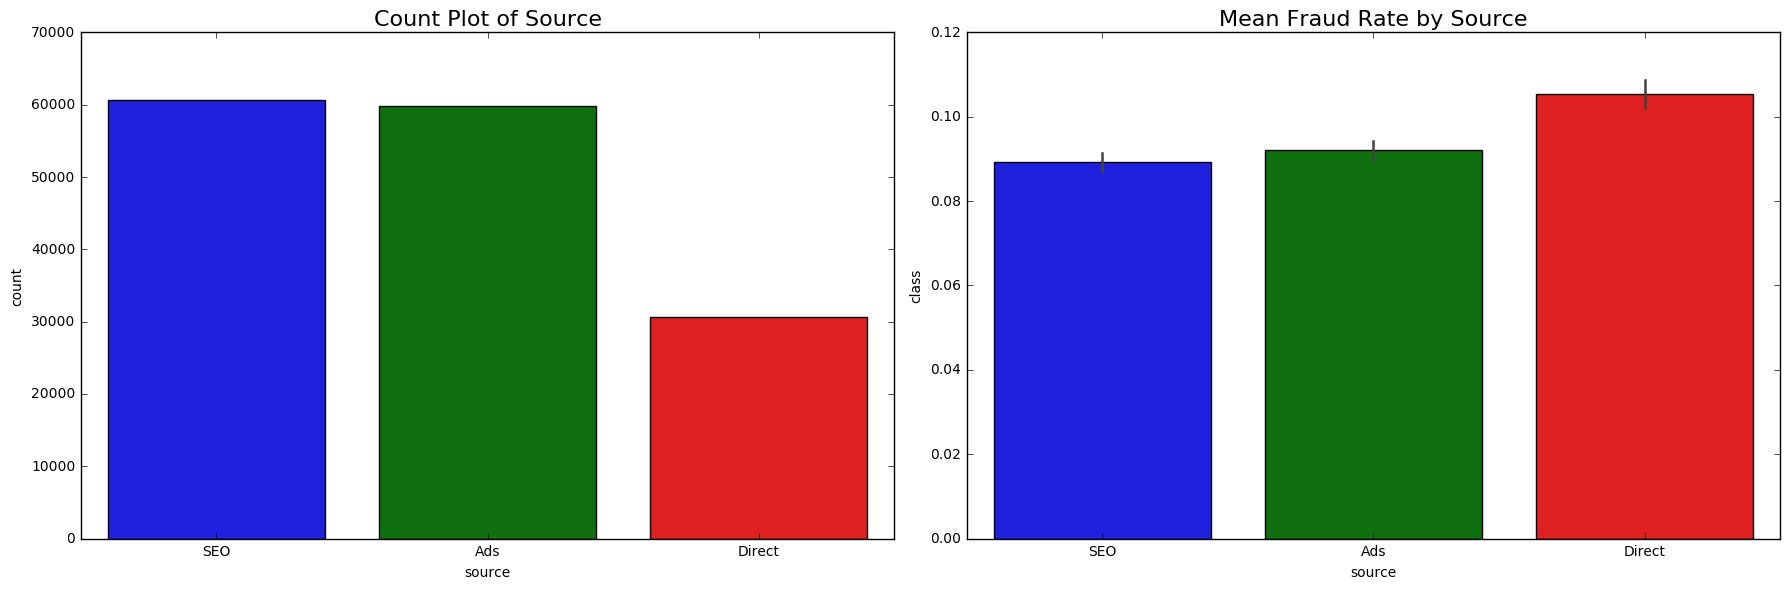

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)

sns.barplot(x='source', y ='class', data = data, ax=ax[1])
ax[1].set_title('Mean Fraud Rate by Source', fontsize=16)
plt.tight_layout()
plt.show()

- IE has the lowest (but not significnat) fraud rate

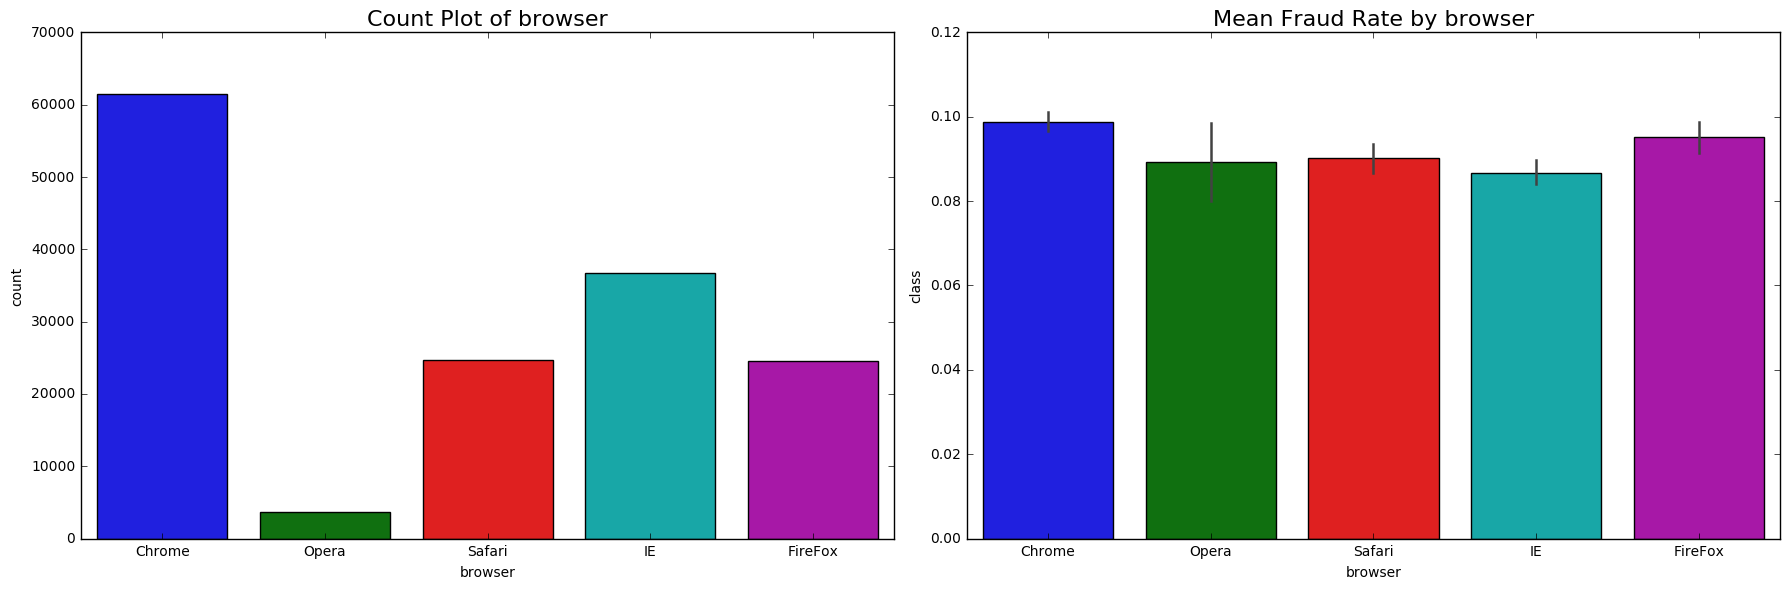

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', data=data, ax=ax[0])
ax[0].set_title('Count Plot of browser', fontsize=16)

sns.barplot(x='browser', y ='class', data = data, ax=ax[1])
ax[1].set_title('Mean Fraud Rate by browser', fontsize=16)
plt.tight_layout()
plt.show()

- Female has lower volume but fraud rate is pretty much the same

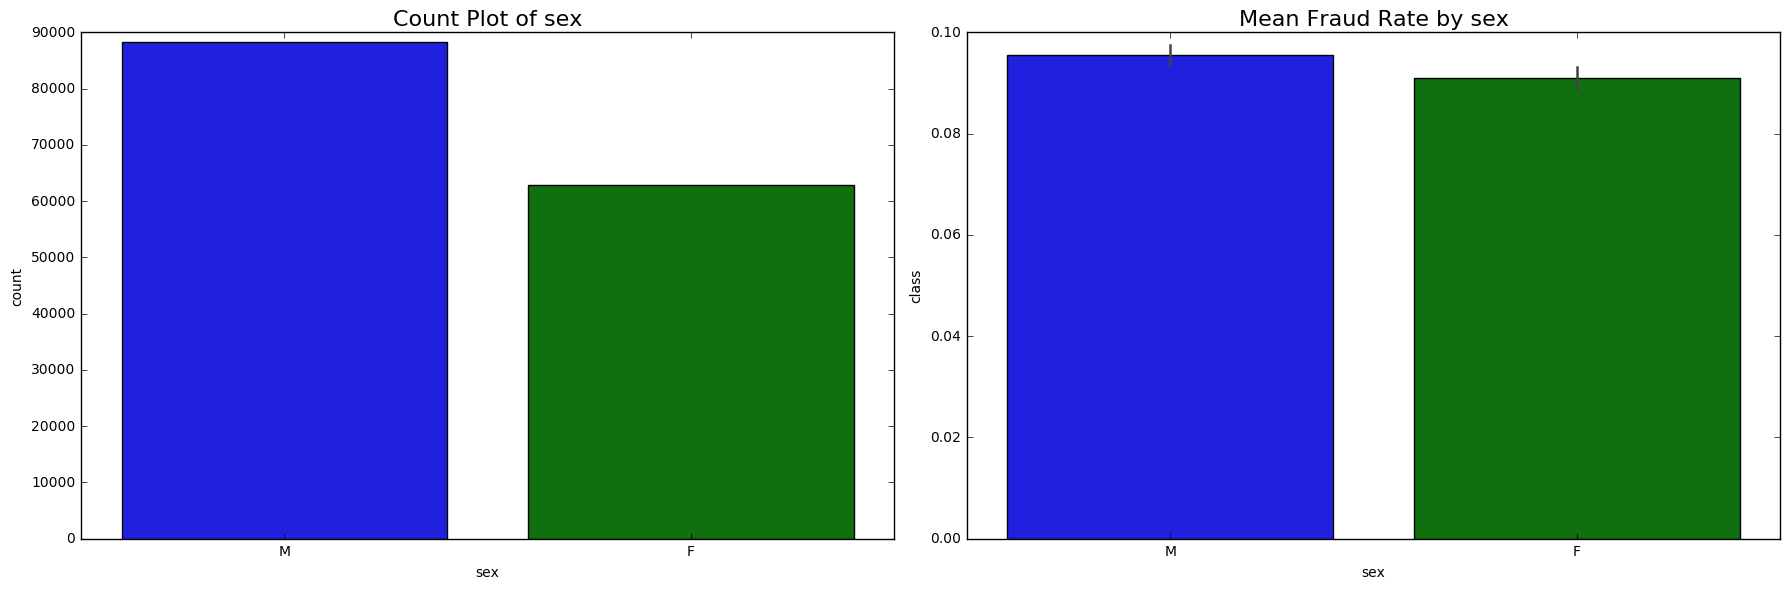

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', data=data, ax=ax[0])
ax[0].set_title('Count Plot of sex', fontsize=16)

sns.barplot(x='sex', y ='class', data = data, ax=ax[1])
ax[1].set_title('Mean Fraud Rate by sex', fontsize=16)
plt.tight_layout()
plt.show()

- Age distribution is right skewed
- Fraud rate is higher with higher age

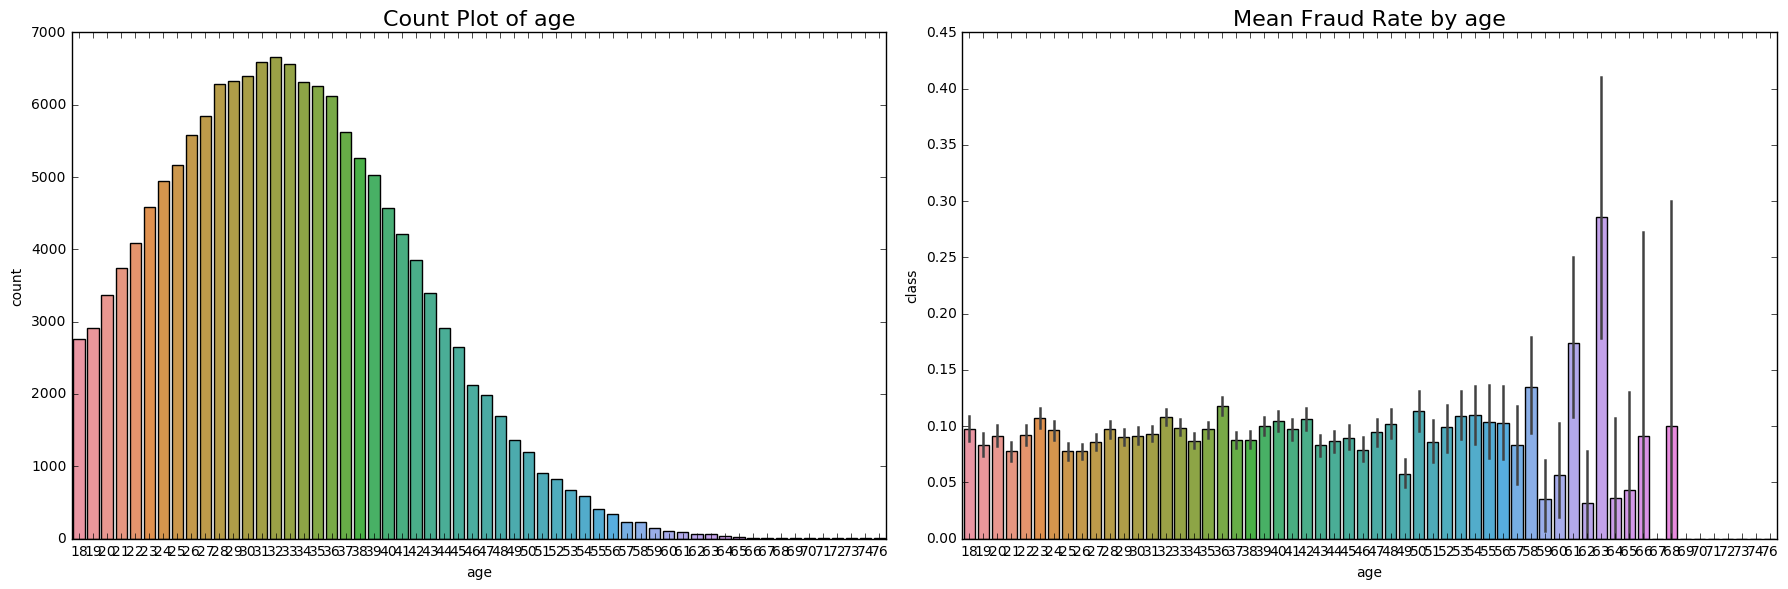

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='age', data=data, ax=ax[0])
ax[0].set_title('Count Plot of age', fontsize=16)

sns.barplot(x='age', y ='class', data = data, ax=ax[1])
ax[1].set_title('Mean Fraud Rate by age', fontsize=16)
plt.tight_layout()
plt.show()

- Purchase value is right skew
- High purchase value has higher fraud rate

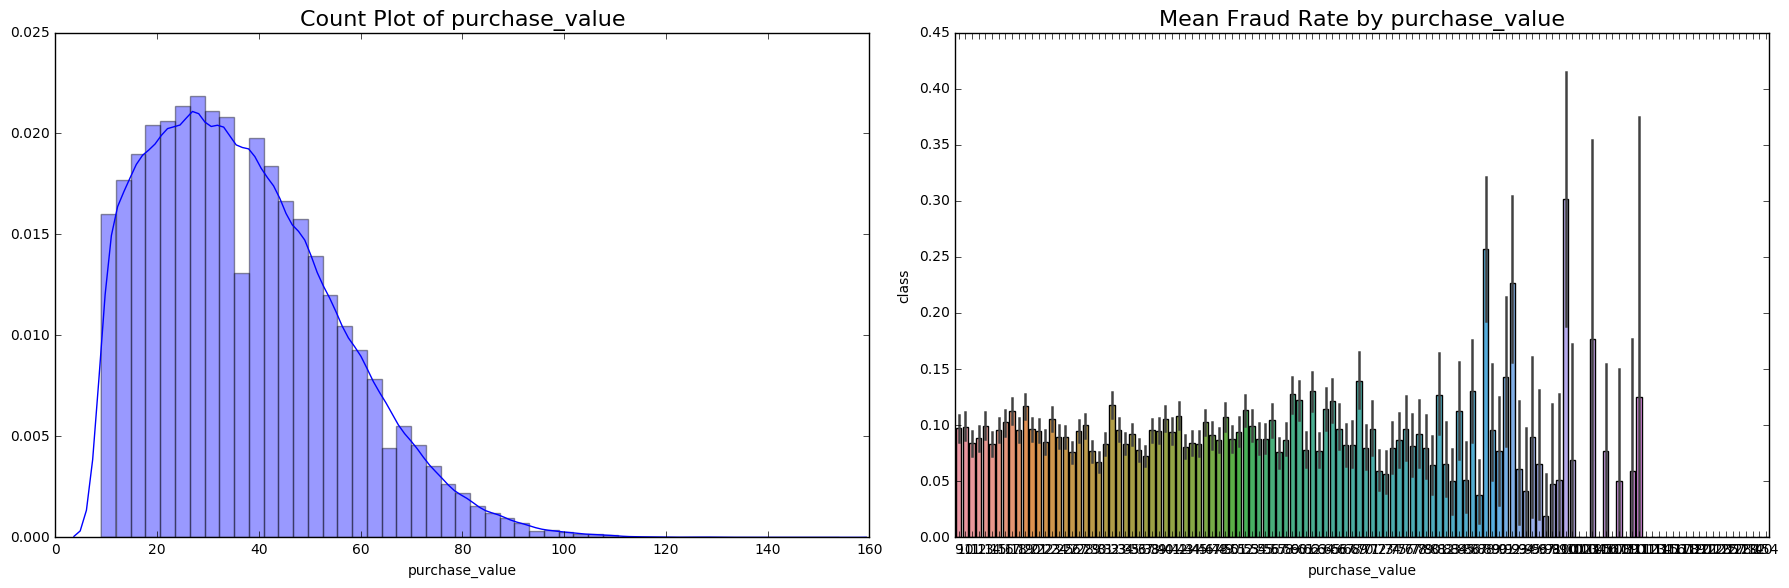

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data['purchase_value'], ax=ax[0])
ax[0].set_title('Count Plot of purchase_value', fontsize=16)

sns.barplot(x='purchase_value', y ='class', data = data, ax=ax[1])
ax[1].set_title('Mean Fraud Rate by purchase_value', fontsize=16)
plt.tight_layout()
plt.show()

## Merge two dataset

In [11]:
countries = []

for i in range(len(data)):
    map_country = ip2country[(data.loc[i, 'ip_address'] >= ip2country.lower_bound_ip_address) & (data.loc[i, 'ip_address'] <= ip2country.upper_bound_ip_address)]
    if len(map_country) == 1:
        countries.append(map_country['country'].values[0])
    else:
        countries.append('NA')
        
data['country'] = countries

In [12]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


## Feature Engineering

- Time difference between sign-up time and purchase time
- If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
- Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
- Usual week of the year and day of the week from time variables

In [13]:
data['purchase_time'] = pd.to_datetime(data['purchase_time'])
data['signup_time'] = pd.to_datetime(data['signup_time'])
time_diff = data['purchase_time'] - data['signup_time']
data['time_diff'] = time_diff.dt.seconds

In [14]:
group = data.groupby('device_id', as_index = False).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'num_device'})
data = data.merge(group, on = 'device_id', how = 'left')

In [15]:
group = data.groupby('ip_address', as_index = False).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'num_ip'})
data = data.merge(group, on = 'ip_address', how = 'left')

In [16]:
# Signup day and week
data['signup_day'] = data['signup_time'].dt.dayofweek
data['signup_week'] = data['signup_time'].dt.week

# Purchase day and week
data['purchase_day'] = data['purchase_time'].dt.dayofweek
data['purchase_week'] = data['purchase_time'].dt.week

## Model Building

In [20]:
data = pd.get_dummies(data, columns = ['source', 'browser', 'sex', 'country', 'signup_day', 'signup_week', 'purchase_day', 'purchase_week'], drop_first=True)

In [84]:
feature_list = data.columns.drop([u'user_id', u'signup_time', u'purchase_time', u'device_id', u'ip_address', u'class'])

In [85]:
train, test = train_test_split(data, test_size = 0.3)
train_X = train[feature_list]
train_y = train['class']
test_x = test[feature_list]
test_y = test['class']

### Logistic Regression

In [68]:
# Logistic 
model = LogisticRegression()
model.fit(train_X,train_y)
prediction=model.predict(test_x)
print 'The accuracy of the Logistic Regression is',metrics.accuracy_score(test_y, prediction)
print 'The roc score of the Logistic Regression is', metrics.roc_auc_score(test_y, prediction)
print 'The precision score of the Logistic Regression is', metrics.precision_score(test_y, prediction)
print 'The recall score of the Logistic Regression is', metrics.recall_score(test_y, prediction)

The accuracy of the Logistic Regression is 0.951824237879
The roc score of the Logistic Regression is 0.754172985831
The precision score of the Logistic Regression is 0.936925098555
The recall score of the Logistic Regression is 0.511844938981


In [69]:
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(test_y, prediction))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(test_y, prediction))

[[41011   144]
 [ 2040  2139]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97     41155
          1       0.94      0.51      0.66      4179

avg / total       0.95      0.95      0.95     45334



## Random Forest

In [70]:
# Random Forest
model = RandomForestClassifier()
model.fit(train_X,train_y)
prediction=model.predict(test_x)
print 'The accuracy of the RF is',metrics.accuracy_score(test_y, prediction)
print 'The roc score of the RF is', metrics.roc_auc_score(test_y, prediction)
print 'The precision score of the RF is', metrics.precision_score(test_y, prediction)
print 'The recall score of the RF is', metrics.recall_score(test_y, prediction)

The accuracy of the RF is 0.957846208144
The roc score of the RF is 0.772969233763
The precision score of the RF is 0.993472584856
The recall score of the RF is 0.546302943288


In [71]:
# the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(test_y, prediction))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(test_y, prediction))

[[41140    15]
 [ 1896  2283]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98     41155
          1       0.99      0.55      0.70      4179

avg / total       0.96      0.96      0.95     45334



num_ip     | 0.17166
time_diff  | 0.16231
purchase_week_2 | 0.10788
num_device | 0.09764
purchase_value | 0.04828
age        | 0.04492
signup_week_2 | 0.02891
sex_M      | 0.01172
browser_IE | 0.00896
country_United States | 0.00890


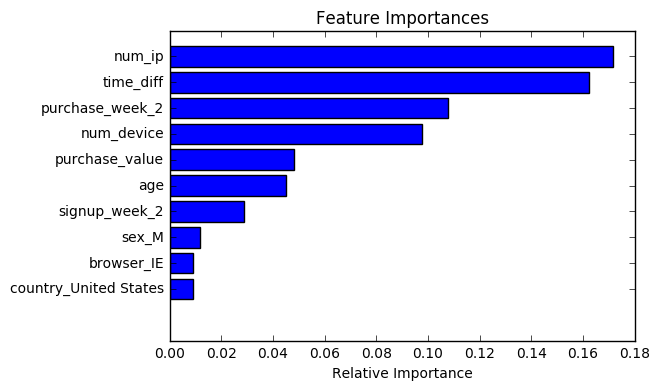

In [72]:
# Feature importance
importance = sorted(zip(feature_list, model.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance[:10]:
    print('{0:10s} | {1:.5f}'.format(feature, val))
    
plt.title('Feature Importances')
plt.barh(range(len(importance[:10])), [val for feature, val in importance[:10]][::-1], color='b', align='center')
plt.yticks(range(len(importance[:10])), [feature for feature, val in importance[:10]][::-1])
plt.xlabel('Relative Importance')
plt.show()

## XGBoost

In [79]:
import xgboost as xgboost
model = xgboost.XGBClassifier(max_depth = 2, silent  = 1, objective = 'binary:logistic')
model.fit(train_X,train_y)
prediction = model.predict_proba(test_x)[:, 1]
prediction = prediction.round()

print 'The accuracy of the RF is',metrics.accuracy_score(test_y, prediction)
print 'The roc score of the RF is', metrics.roc_auc_score(test_y, prediction)
print 'The precision score of the RF is', metrics.precision_score(test_y, prediction)
print 'The recall score of the RF is', metrics.recall_score(test_y, prediction)

The accuracy of the RF is 0.957890325142
The roc score of the RF is 0.771811068929
The precision score of the RF is 0.999120492524
The recall score of the RF is 0.543670734626


In [76]:
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(test_y, prediction.round()))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(test_y, prediction.round()))

[[41153     2]
 [ 1907  2272]]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98     41155
          1       1.00      0.54      0.70      4179

avg / total       0.96      0.96      0.95     45334



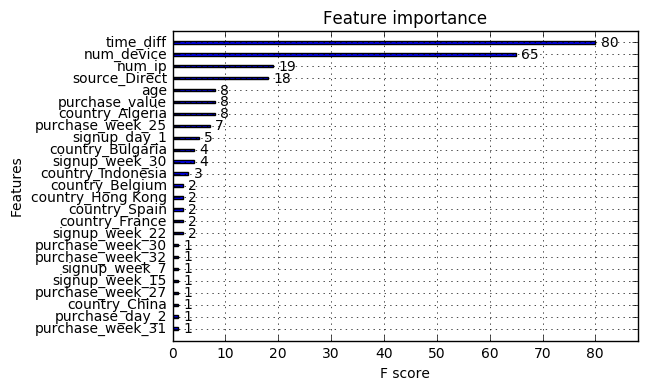

In [77]:
xgb.plot_importance(model)

## Compare models

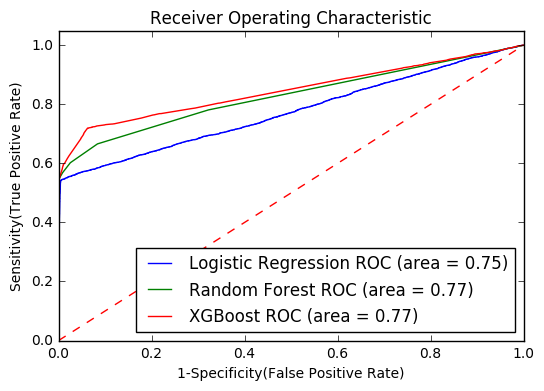

In [78]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'XGBoost',
    'model': xgboost.XGBClassifier(max_depth = 2, silent  = 1, objective = 'binary:logistic'),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(train_X,train_y) # train the model
    y_pred=model.predict(test_x) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(test_y, model.predict_proba(test_x)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(test_y, model.predict(test_x))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display